In [23]:
using TaylorSeries

In [24]:
println(VERSION)

using Compat

0.

In [25]:
using PyPlot

Implementamos agunas funciones entre tipos Taylor1 que necesitaremos para esolver nuestras ecuaciones diferenciales como: $tanh(x)=\frac{ e^ x - e ^{-x} }{ e^x + e ^{-x} }$, valor absoluto y la parte positiva de una funci√≥n.

In [26]:
import Base.tanh
import Base.abs

In [27]:
tanh(b::Taylor1)=(exp(b)-exp(-b))/(exp(b)+exp(-b))

tanh (generic function with 14 methods)

In [28]:
tanh(Taylor1([1,2]))

 0.7615941559557649 + 0.8399486832280523 t + ùí™(t¬≤)

In [29]:
abs(c::Taylor1)=(c^2)^0.5

abs (generic function with 32 methods)

Para sacar la parte positiva, hacemos lo siguiente:

In [30]:
p_f(f)=(abs(f)+f)/2.0

p_f (generic function with 1 method)

Ahora probemos esta funci√≥n:

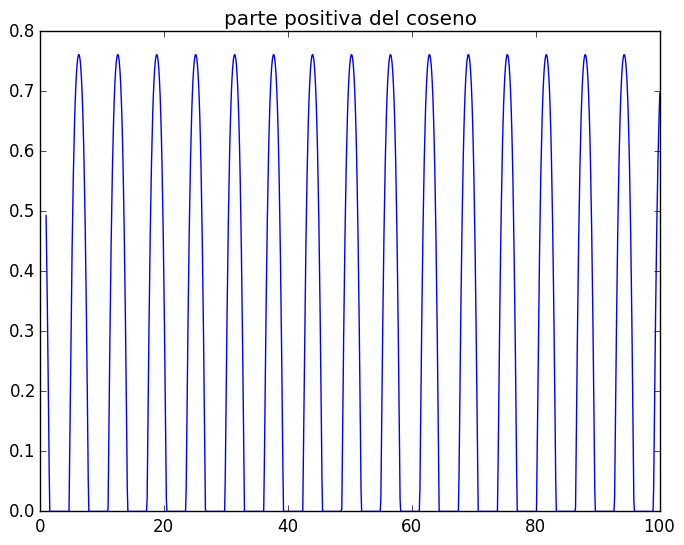

PyObject <matplotlib.text.Text object at 0x7fc3b6bf03c8>

4.1


In [31]:
dieg=1:.1:100
aix=[tanh(p_f(cos(i))) for i in dieg];
mari=[(((cos(i))^2)^0.5 +cos(i))*0.5 for i in dieg]
plot(dieg,aix)
title("parte positiva del coseno")

Ahora haremos m√°s legible a running:

In [32]:
# Funci√≥n Running: determina los coeficientes de la series de Taylor seg√∫n las ecuaciones anteriores.
function Running{T<:Real}(vec::Array{T,1} , N::Int, t::Float64) # La funci√≥n pide un arreglo con los puntos alrededor
    # de los cuales se obtendr√°n las series, el m√°ximo coeficiente N del polinomio de Taylor
    xinT = Taylor1(vec[1], N)# Los primeros t√©rminos de la serie x0 y y0 
    xexT = Taylor1(vec[2], N)
    xMRT = Taylor1(vec[3], N)    
    rT = Taylor1(vec[4], N)
    œïT = Taylor1(vec[5], N) 
    
    A=1.0; H=5.0; Œ±=1.0; B=50.0; m=20; K=1 ; œâ=sqrt(K/m) #K constante del resorte
    œâ_0=(1+tanh(1))*0.5

    for k = 0:N-1
        knext = k+1
        # Las siguientes series contienen los coeficientes hasta k
        # los cuales son necesarios en las ecuaciones de recurrencia
        # para obtener el coeficiente k+1
        xinTt = Taylor1( xinT.coeffs[1:k+1], k)
        xexTt = Taylor1( xexT.coeffs[1:k+1], k)
        xMRTt = Taylor1( xMRT.coeffs[1:k+1], k)
        rTt = Taylor1( rT.coeffs[1:k+1], k)
        œïTt = Taylor1( œïT.coeffs[1:k+1], k)
        # Las ecuaciones de movimiento, determinadas
        cxin = cos(xinTt)
        cxex = cos(xexTt)
        cxMR = cos(xMRTt)
        z = rTt*cos(œïTt)
        
        p_in=p_f(cos(xinTt)) #partes positivas del coseno 
        p_ex=p_f(cos(xexTt))
        p_MR=p_f(cos(xMRTt))
        p_z=p_f(z) #parte positiva de z
       
        F=B*(p_in-p_ex) #F=B(V(xin)-V(xex))+p(t)=d(cos(xin)-cos(xex)), p=cte

        
        Dxin =.005+ tanh(A*cos(xinTt)+Œ±-H*p_f(cos(xMRTt))) #Ahora s√≥lo sustituimos las ecuaciones diferenciales
        Dxex =.005+A*cos(xexTt)+Œ±-H*p_in
        DxMR = .005+tanh(cxMR+H*p_z)
        Dr = -(z^2)/(m*rTt) +sin(œïTt)*F/sqrt(K*m)
        Dœï = -œâ+cos(œïTt)*F/(rTt*sqrt(K*m)) -sin(œïTt)*cos(œïTt)/m 
       
        # Los t√©rminos k+1 est√°n determinados por (1)
        xinT.coeffs[knext+1]  = Dxin.coeffs[knext] / knext
        xexT.coeffs[knext+1]  = Dxex.coeffs[knext] / knext
        xMRT.coeffs[knext+1]  = DxMR.coeffs[knext] / knext
        rT.coeffs[knext+1]  = Dr.coeffs[knext] / knext
        œïT.coeffs[knext+1]  = Dœï.coeffs[knext] / knext
    end
    # Se devuelven los resultados
    return Taylor1[xinT, xexT, xMRT, rT, œïT]
end

Running (generic function with 1 method)

In [33]:
# Funci√≥n paso: determina el tama√±o de paso para la integraci√≥n
# por m√©todo de Taylor.
function paso{T<:Real}(x::Taylor1{T}, epsilon::Float64)# Se introduce un polinomio de Taylor y el epsilon
    k = x.order# Orden del polinomio
    h = 1.0# Iniciamos h
    for i in [k-1, k]# Iteramos solo para los dos primeros t√©rminos del polinomio
        aux = abs( x.coeffs[i+1] )
        h = min(h, (epsilon/aux)^(1.0/i))# Nos quedamos con el m√≠nimo
    end
    return h # La funci√≥n devuelve h
end

paso (generic function with 1 method)

In [56]:
# Funci√≥n evaluador: Determina los coeficientes despu√©s de cada paso.
function evaluador{T<:Number}( Eqs::Function, vec0::Array{T,1}, N::Int, epsilon::Float64, t::Float64)# La funci√≥n solicita las ecuaciones
    # a resolver, un arreglo de condiciones iniciales, N que indica el m√°ximo coeficiente de expansi√≥n y la epsil√≥n.
    
    n = length(vec0)# Definimos algunas cantidades de utilidad
    vec1T = Eqs(vec0, N, t)# Resolvemos las ecuaciones con las condiciones iniciales
    
    # Obtenemos h para cada serie usando la funci√≥n paso
    hh = vec0
    for i in eachindex(vec1T)
        hh[i] = paso(vec1T[i], epsilon)
    end
    
    # Tomamos el m√≠nimo de los h's
    hfin = hh[1]
    for i in eachindex(hh)
        hfin = min(hfin,hh[i])
    end
    
    # Se determinan los valores del nuevo arreglo
    for i=1:n
        vec0[i] = evaluate(vec1T[i], hfin)
    end
    
    return hfin, vec0# Devolvemos los resultados
end

evaluador (generic function with 2 methods)

In [101]:
# Funci√≥n Integrador_1: contiene las ecuaciones a resolver usando el m√©todo de integraci√≥n de Taylor
function Integrador_1(t_max::Float64, Eqs::Function, epsilon::Float64, N::Int,xin0, xex0, xMR0, r0, œï0)
    # Usar√° las funciones antes desarrolladas, este funci√≥n pide un tiempo m√°ximo de operaci√≥n, las ecuaciones
    # a resolver, el epsil√≥n y el orden del polinomio de Taylor
    t0 = 0.0# Iniciamos el tiempo
   # xin0, xex0, xMR0, r0, œï0 =x0# Condiciones iniciales. AIXA: Te recomiendo que juegues con
    # las condiciones iniciales, aqu√≠ debe de estar el truco para obtener las gr√°ficas que queriamos.
    
    
    tV, xinV, xexV, xMRV, rV, œïV = Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]# Aqu√≠ se ubicar√°n los resultados
    push!(tV, t0)
    push!(xinV, xin0)# COlocamos condiciones iniciales
    push!(xexV, xex0)
    push!(xMRV, xMR0)
    push!(rV, r0)
    push!(œïV, œï0)

    # Resolvemos para cada tiempo
    dt = 1.0# Paso inicial
    while t0 < t_max && dt>1.0e-8# Condiciones de paro
        
        dt, res = evaluador(Eqs, [xin0, xex0, xMR0, r0, œï0], N, epsilon, t0)# Resolvemos
        t0 += dt# A t0 se le suma el tama√±o de paso
        push!(tV,t0)
        push!(xinV,res[1])# Los resultados se guardan
        push!(xexV,res[2])
        push!(xMRV,res[3])# Los resultados se guardan
        push!(rV,res[4])
        push!(œïV,res[5])
        xin0, xex0, xMR0, r0, œï0 = res[1], res[2], res[3], res[4], res[5]# Nuevas condiciones iniciales
    end

    return tV, xinV, xexV, xMRV, rV, œïV# Devuelve los resultados
end

Integrador_1 (generic function with 1 method)

In [102]:
rest, resxin, resxex, resxMR, resr, resœï = Integrador_1(500.0,Running,10.0^(-10),20,œÄ,œÄ/3,2*œÄ,1.0,0.0);

In [103]:
function z(t_max::Float64, Eqs::Function, epsilon::Float64, N::Int,xin0, xex0, xMR0, r0, œï0)
   rest, resxin, resxex, resxMR, resr, resœï = Integrador_1(t_max::Float64, Eqs::Function, epsilon::Float64, N::Int,xin0, xex0, xMR0, r0, œï0)
   Z = resr
    for i in eachindex(resr)
    Z[i] = resr[i]*cos(resœï[i])
end
    hcat(rest,Z)
end

z (generic function with 1 method)

In [104]:
hola=z(500.0,Running,10.0^(-10),20,2*œÄ,2*œÄ,2*œÄ,1.0,0.0);

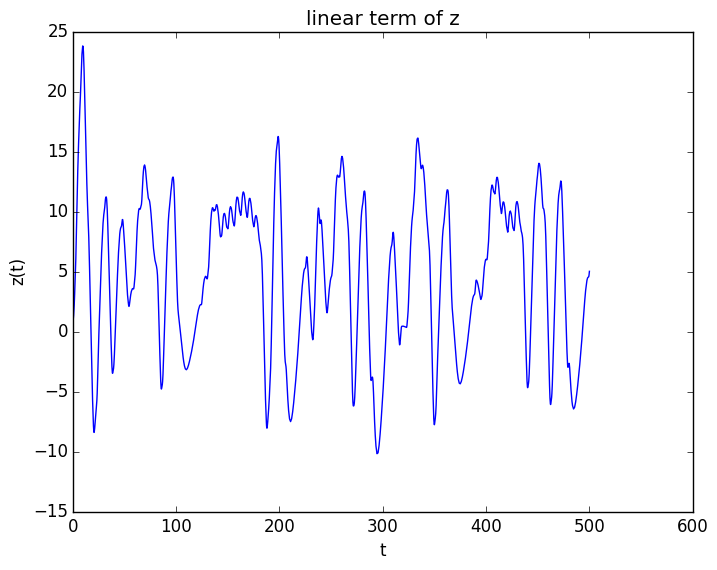

In [105]:
plot(hola[:,1],hola[:,2])
xlabel("t")
ylabel("z(t)")
title("linear term of z")
legend();

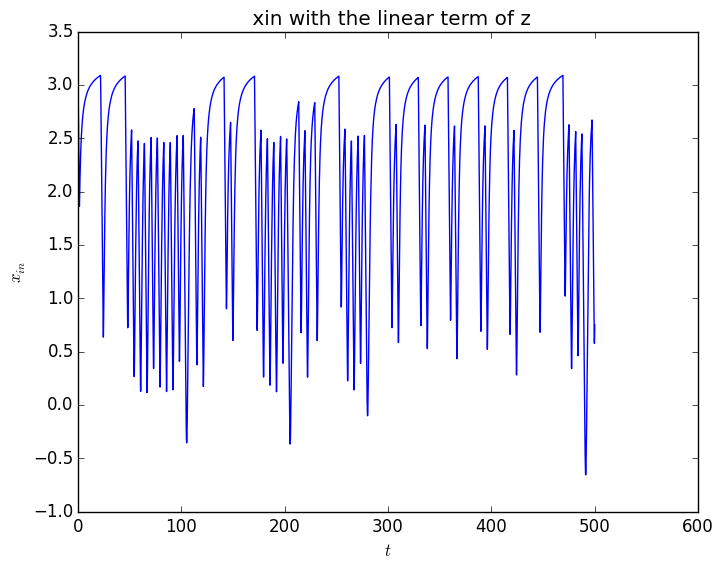

In [106]:
plot(rest,resxin)
xlabel(L"t")
ylabel(L"x_{in}")
title(" xin with the linear term of z")
legend();

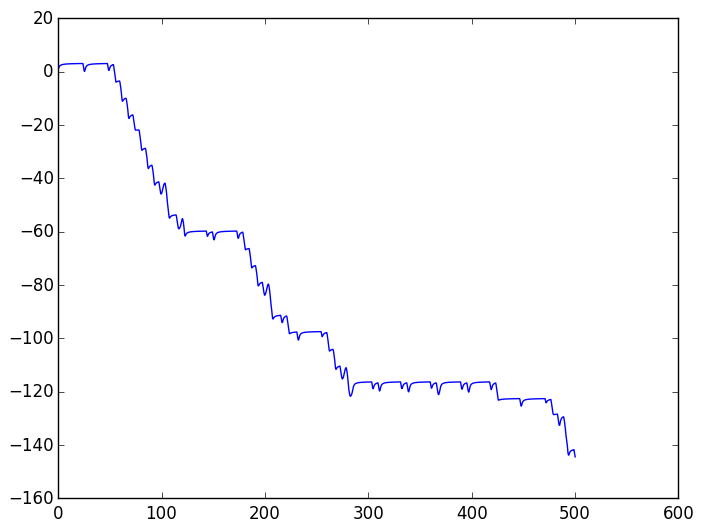

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc3b69fe908>

In [107]:
plot(rest,resxex)

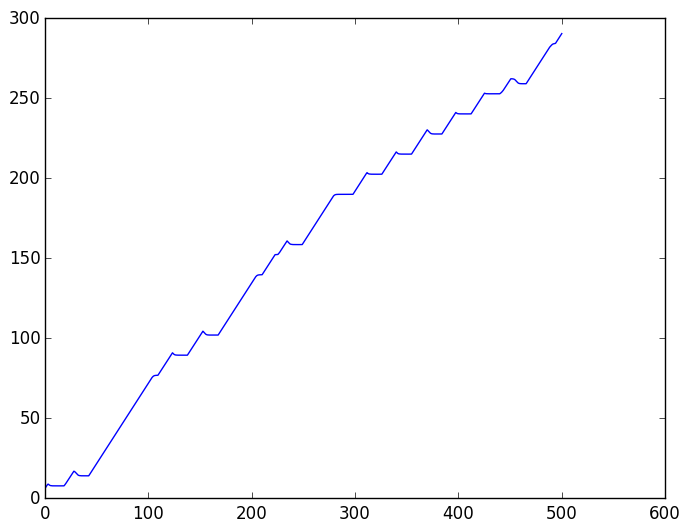

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc3b5cf2240>

In [108]:
plot(rest,resxMR)

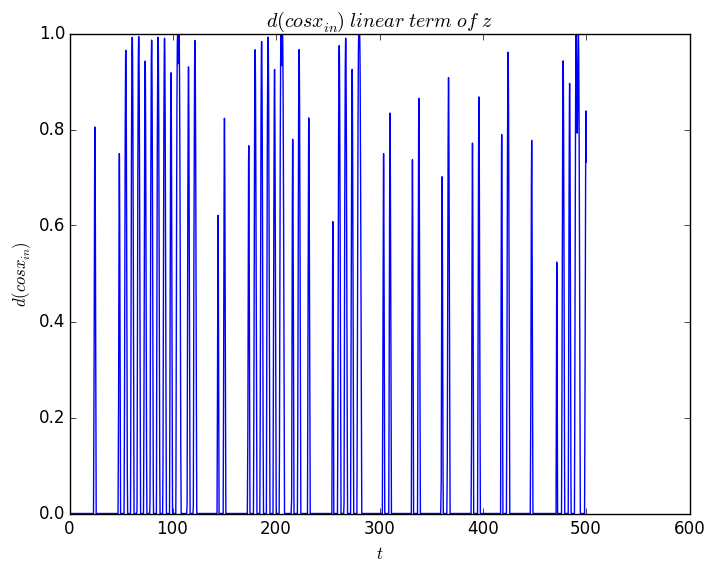

In [109]:
plot(rest,p_f(cos(resxin)))
xlabel(L"t")
ylabel(L"d(cosx_{in})")
title(L"d(cosx_{in}) \ linear \ term \ of  \ z")
legend();

## Non linear spring

Sustituyendo el t√©rmino $kz$ por $k(z+z^3)$, esto se plante√≥ y resolvi√≥ en el notebook de respiraci√≥n 

$\frac{dr}{dt}=\frac{‚àíFcos(œï(t))}{\sqrt{km} \ r(t)cos(2œï(t))}+\frac{œâr^2(t)sin^4(œï(t))}{cos(2œï(t))}+œâr^2(t)+\frac{œâ}{cos(2œï(t))}‚àí\frac{1}{2m}tan(2œï(t))$

$\frac{\phi}{dt}=\frac{1}{m \sqrt{km} \cos(2œï)}(m  \ sinœï \ (‚àíF+ \omega \sqrt{km} \ r^3(t)\cos^3(œï)+œâ\sqrt{km} \ rcos(œï))‚àí\frac{\sqrt{km}}{2}(‚àímœâ\sin(2œï)+cos(2œï)+1)r$


In [119]:
cos(Taylor1([3,4]))^3

 - 0.9702769379215033 - 1.6597154799048712 t + ùí™(t¬≤)

Estas ecuaciones diferencial las implementaremos en la funci√≥n $non\_linear\_r$

In [177]:
# Funci√≥n Running: determina los coeficientes de la series de Taylor seg√∫n las ecuaciones anteriores.
function non_linear_r{T<:Real}(vec::Array{T,1} , N::Int, t::Float64) # La funci√≥n pide un arreglo con los puntos alrededor
    # de los cuales se obtendr√°n las series, el m√°ximo coeficiente N del polinomio de Taylor
    xinT = Taylor1(vec[1], N)# Los primeros t√©rminos de la serie x0 y y0 
    xexT = Taylor1(vec[2], N)
    xMRT = Taylor1(vec[3], N)    
    rT = Taylor1(vec[4], N)
    œïT = Taylor1(vec[5], N) 
    
    A=1.0; H=5.0; Œ±=1.0; B=50.0; m=20; K=1 ; œâ=sqrt(K/m) #K constante del resorte
     raiz=sqrt(K*m)
    œâ_0=(1+tanh(1))*0.5

    for k = 0:N-1
        knext = k+1
        # Las siguientes series contienen los coeficientes hasta k
        # los cuales son necesarios en las ecuaciones de recurrencia
        # para obtener el coeficiente k+1
        xinTt = Taylor1( xinT.coeffs[1:k+1], k)
        xexTt = Taylor1( xexT.coeffs[1:k+1], k)
        xMRTt = Taylor1( xMRT.coeffs[1:k+1], k)
        rTt = Taylor1( rT.coeffs[1:k+1], k)
        œïTt = Taylor1( œïT.coeffs[1:k+1], k)
        # Las ecuaciones de movimiento, determinadas
        cxin = cos(xinTt)
        cxex = cos(xexTt)
        cxMR = cos(xMRTt)
        z = rTt*cos(œïTt)
        
        p_in=p_f(cos(xinTt)) #partes positivas del coseno 
        p_ex=p_f(cos(xexTt))
        p_MR=p_f(cos(xMRTt))
        p_z=p_f(z) #parte positiva de z
       
        F=B*(p_in-p_ex) #F=B(V(xin)-V(xex))+p(t)=d(cos(xin)-cos(xex)), p=cte

        
        Dxin = œâ_0+tanh(A*cxin+Œ±-H*p_MR) #Ahora s√≥lo sustituimos las ecuaciones diferenciales
        Dxex = œâ_0+(A*cxex+Œ±-H*p_in)
        DxMR = œâ_0+tanh(cxMR+H*p_z)
      
        
Dr=-F*cos(œïTt)/(raiz*rTt*cos(2*œïTt)) + œâ*rTt^2*sin(œïTt)^4/(cos(2*œïTt)) + œâ*rTt^2 +œâ/cos(2*œïTt) -0.5*tan(2*œïTt)/m
Dœï= (m*sin(œïTt)/(m*raiz*cos(2*œïTt)))*(-F+œâ*raiz*rTt^3*cos(œïTt)^3+œâ*raiz*rTt*cos(œïTt))-raiz*rTt*0.5*(-m*œâ*sin(œïTt)+cos(2*œïTt)+1)
       
        # Los t√©rminos k+1 est√°n determinados por (1)
        xinT.coeffs[knext+1]  = Dxin.coeffs[knext] / knext
        xexT.coeffs[knext+1]  = Dxex.coeffs[knext] / knext
        xMRT.coeffs[knext+1]  = DxMR.coeffs[knext] / knext
        rT.coeffs[knext+1]  = Dr.coeffs[knext] / knext
        œïT.coeffs[knext+1]  = Dœï.coeffs[knext] / knext
    end
    # Se devuelven los resultados
    return Taylor1[xinT, xexT, xMRT, rT, œïT]
end

non_linear_r (generic function with 1 method)

In [178]:
rest, resxin, resxex, resxMR, resr, resœï = Integrador_1(500.0,non_linear_r,10.0^(-10),20,2*œÄ,2*œÄ,2*œÄ,1.0,0.0);

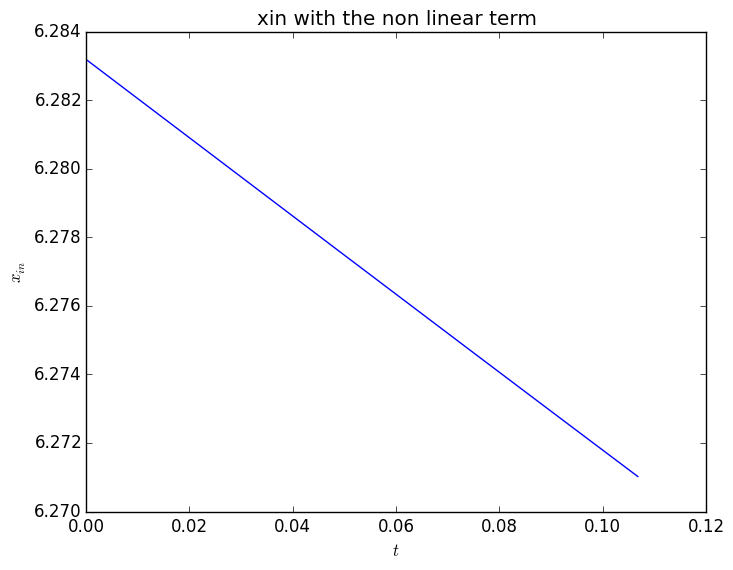

In [179]:
plot(rest,resxin)
title("xin with the non linear term")
xlabel(L"t")
ylabel(L"x_{in}")
legend();

In [180]:
hola_1=z(1000.0,non_linear_r,10.0^(-10),30,œÄ,œÄ,2*œÄ,1.0,0.0)

17x2 Array{Float64,2}:
 0.0        1.0     
 0.0614153  0.956918
 0.0864528  0.865745
 0.0965248  0.811646
 0.100501   0.787961
 0.102034   0.77912 
 0.10261    0.776355
 0.10282    0.775775
 0.102894   0.775854
 0.10292    0.776058
 0.102928   0.776232
 0.102931   0.776349
 0.102931   0.776421
 0.102932   0.776462
 0.102932   0.776484
 0.102932   0.776496
 0.102932   0.776502

In [181]:
hola_1[:,2]

17-element Array{Float64,1}:
 1.0     
 0.956918
 0.865745
 0.811646
 0.787961
 0.77912 
 0.776355
 0.775775
 0.775854
 0.776058
 0.776232
 0.776349
 0.776421
 0.776462
 0.776484
 0.776496
 0.776502

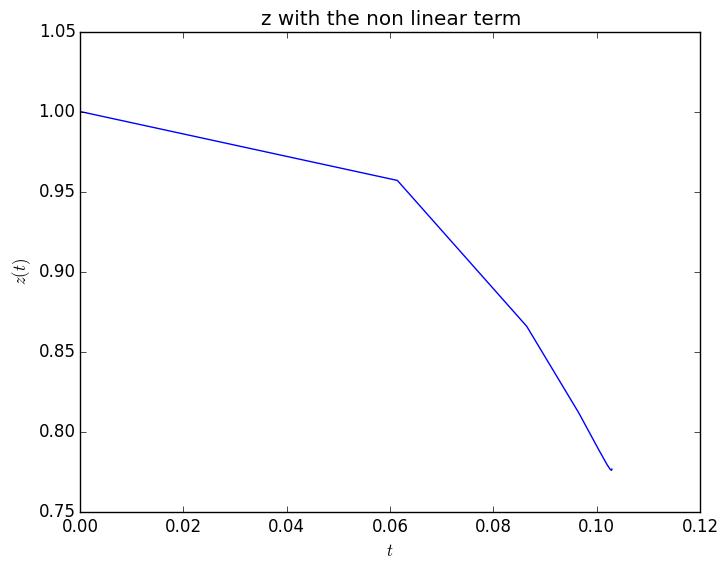

In [182]:
plot(hola_1[:,1],hola_1[:,2])
title("z with the non linear term")
xlabel(L"t")
ylabel(L"z(t)")
legend();

In [183]:
# Funci√≥n Running: determina los coeficientes de la series de Taylor seg√∫n las ecuaciones anteriores.
function non_linear_sin_tanh{T<:Real}(vec::Array{T,1} , N::Int, t::Float64) # La funci√≥n pide un arreglo con los puntos alrededor
    # de los cuales se obtendr√°n las series, el m√°ximo coeficiente N del polinomio de Taylor
    xinT = Taylor1(vec[1], N)# Los primeros t√©rminos de la serie x0 y y0 
    xexT = Taylor1(vec[2], N)
    xMRT = Taylor1(vec[3], N)    
    rT = Taylor1(vec[4], N)
    œïT = Taylor1(vec[5], N) 
    
    A=1.0; H=5.0; Œ±=1.0; B=50.0; m=4; K=1 ; œâ=sqrt(K/m) #K constante del resorte
     raiz=sqrt(K*m)
    v=0.5
    œâ_0=(1+tanh(1))*0.5

    for k = 0:N-1
        knext = k+1
        # Las siguientes series contienen los coeficientes hasta k
        # los cuales son necesarios en las ecuaciones de recurrencia
        # para obtener el coeficiente k+1
        xinTt = Taylor1( xinT.coeffs[1:k+1], k)
        xexTt = Taylor1( xexT.coeffs[1:k+1], k)
        xMRTt = Taylor1( xMRT.coeffs[1:k+1], k)
        rTt = Taylor1( rT.coeffs[1:k+1], k)
        œïTt = Taylor1( œïT.coeffs[1:k+1], k)
        # Las ecuaciones de movimiento, determinadas
        cxin = cos(xinTt)
        cxex = cos(xexTt)
        cxMR = cos(xMRTt)
        z = rTt*cos(œïTt)
        
        p_in=p_f(cos(xinTt)) #partes positivas del coseno 
        p_ex=p_f(cos(xexTt))
        p_MR=p_f(cos(xMRTt))
        p_z=p_f(z) #parte positiva de z
       
        F=B*(p_in-p_ex) #F=B(V(xin)-V(xex))+p(t)=d(cos(xin)-cos(xex)), p=cte

        
        Dxin = œâ_0+tanh(v)*(A*cxin+Œ±-H*p_MR) #Ahora s√≥lo sustituimos las ecuaciones diferenciales
        Dxex = œâ_0+(A*cxex+Œ±-H*p_in)
        DxMR = œâ_0+tanh(v)*(cxMR+H*p_z)
      
        
Dr=-F*cos(œïTt)/(raiz*rTt*cos(2*œïTt)) + œâ*rTt^2*sin(œïTt)^4/(cos(2*œïTt)) + œâ*rTt^2 +œâ/cos(2*œïTt) -0.5*tan(2*œïTt)/m
        Dœï= (m*sin(œïTt)/(m*raiz*cos(2*œïTt)))*(-F+œâ*raiz*rTt^3*cos(œïTt)^3+œâ*raiz*rTt*cos(œïTt))-raiz*rTt*0.5*(-m*œâ*sin(œïTt)+cos(2*œïTt)+1)
       
        # Los t√©rminos k+1 est√°n determinados por (1)
        xinT.coeffs[knext+1]  = Dxin.coeffs[knext] / knext
        xexT.coeffs[knext+1]  = Dxex.coeffs[knext] / knext
        xMRT.coeffs[knext+1]  = DxMR.coeffs[knext] / knext
        rT.coeffs[knext+1]  = Dr.coeffs[knext] / knext
        œïT.coeffs[knext+1]  = Dœï.coeffs[knext] / knext
    end
    # Se devuelven los resultados
    return Taylor1[xinT, xexT, xMRT, rT, œïT]
end

non_linear_sin_tanh (generic function with 1 method)

In [184]:
rest, resxin, resxex, resxMR, resr, resœï = Integrador_1(500.0,non_linear_sin_tanh,10.0^(-10),20,2*œÄ,2*œÄ,2*œÄ,1.0,0.0);

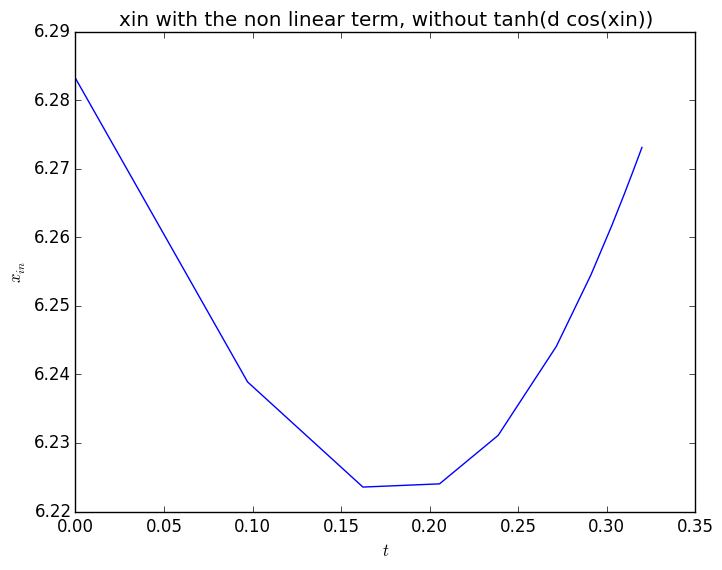

In [185]:
plot(rest,resxin)
title("xin with the non linear term, without tanh(d cos(xin))")
xlabel(L"t")
ylabel(L"x_{in}")
legend();

### No entiendo en qu√© punto se linealiza de esta manera!!!!!

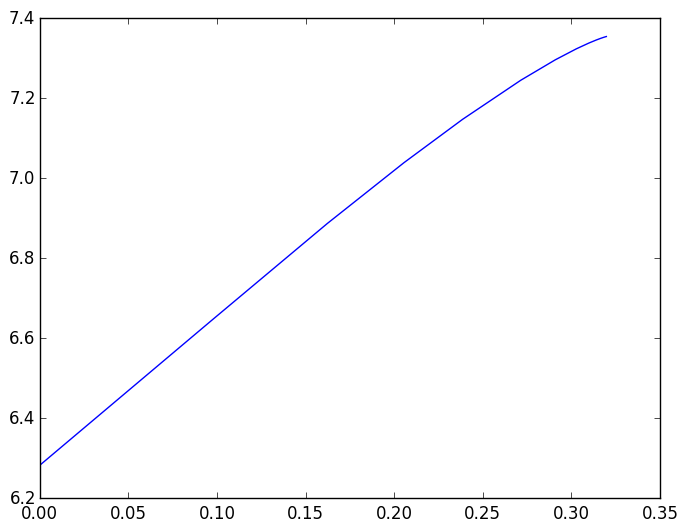

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc3b5d3bf28>

In [167]:
plot(rest,resxMR)